In [1]:
# !pip install -q transformers[sentencepiece]
# !pip install -q datasets
# !pip install -q sacrebleu
# !pip uninstall -y tqdm
# !pip install -q tqdm

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from datasets import Dataset,load_metric
from sklearn.model_selection import train_test_split
import torch
from tqdm.auto import tqdm
from transformers import DataCollatorForSeq2Seq, MarianConfig, MarianMTModel, MarianTokenizer,  AdamW
checkpoint = 'Helsinki-NLP/opus-mt-en-ru' # предобученная модель EN-RU

## Подготовка датафрейма

In [3]:
# чтение файла
df = pd.read_csv('content/Russian.csv')

In [4]:
df.head(3)

,INDEX,EN,RU
0,CCMatrix-v1,Security of online payments:,Безопасность онлайн Платежей:
1,CCMatrix-v1,"The quality, alongside several other advantage...","Эти, а также многие другие преимущества делают..."
2,CCAligned-v1,science & research,Наука и исследования


In [5]:
# удаление постороннего столбца
df.drop('INDEX', axis=1, inplace=True)

In [6]:
df.head(3)

,EN,RU
0,Security of online payments:,Безопасность онлайн Платежей:
1,"The quality, alongside several other advantage...","Эти, а также многие другие преимущества делают..."
2,science & research,Наука и исследования


In [7]:
# исходный размер
df.shape

(100000, 2)

In [8]:
# число пропущенных данных
df.isnull().sum()

EN      0
RU    105
dtype: int64

In [9]:
# Избавились от пустых значений (но прочий мусор следует удалять вручную!)
df.dropna(axis = 0, inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [10]:
# Нулевые значенения отсутствуют
df.isnull().sum()

EN    0
RU    0
dtype: int64

In [11]:
df.head(3)

,EN,RU
0,Security of online payments:,Безопасность онлайн Платежей:
1,"The quality, alongside several other advantage...","Эти, а также многие другие преимущества делают..."
2,science & research,Наука и исследования


In [12]:
# Конечный размер
df.shape

(99895, 2)

In [13]:
# Оставим всего n-процентов первых данных от исходного набора
n = 5
df = df.head(int(len(df)*(n/100)))

In [14]:
# Размер данных, который будем использовать
df.shape

(4994, 2)

In [15]:
# разбиение на учебные и тестовые данных
train_df, val_df = train_test_split(df, random_state=42, test_size=0.2)

In [16]:
# размеры учебных и тестовых данных
train_df.shape, val_df.shape

((3995, 2), (999, 2))

## Настройка

In [17]:
# выбор железа для обучения
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

C:\Users\e.boltachev\Anaconda3\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [18]:
device

device(type='cpu')

In [19]:
# гиперпараметры
max_length = 512
batch_size = 8
learning_rate = 1e-5

## Описательная статистика 

### Английский язык

In [20]:
length_list = [len(i) for i in train_df.EN]
data = pd.DataFrame({'Распределение длины английских предложений': length_list})

In [21]:
data.describe()

,Распределение длины английских предложений
count,3995.000000
mean,103.423029
std,90.403254
min,3.000000
25%,41.000000
50%,80.000000
75%,142.000000
max,2387.000000


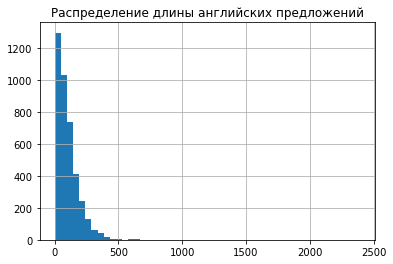

In [22]:
data.hist(bins=50);

### Русский язык

In [23]:
length_list = [len(i) for i in train_df.RU]
data = pd.DataFrame({'Распределение длины русских предложений': length_list})

In [24]:
data.describe()

,Распределение длины русских предложений
count,3995.000000
mean,107.318899
std,87.885079
min,3.000000
25%,42.000000
50%,83.000000
75%,147.500000
max,814.000000


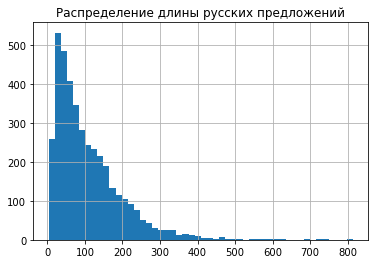

In [25]:
data.hist(bins=50);

## Формирование JSON из нашего датасета

In [26]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
train_dataset = train_dataset.remove_columns(['__index_level_0__'])
val_dataset = val_dataset.remove_columns(['__index_level_0__'])

In [27]:
train_dataset, val_dataset

(Dataset({
     features: ['EN', 'RU'],
     num_rows: 3995
 }),
 Dataset({
     features: ['EN', 'RU'],
     num_rows: 999
 }))

## Загрузка предобученных модели и токенизатора

In [2]:
model = MarianMTModel.from_pretrained(checkpoint)
tokenizer = MarianTokenizer.from_pretrained(checkpoint)

### Токенизатор

***Следующий вывод отражает:***
* размер словаря 62518 токенов
* максимальная длина входной последовательности 512
* ```</s>``` - токен окончания предложения
* ```<unk>``` - токен неизвестного слова в предложении
* ```<pad>``` - токен заполнения

In [29]:
tokenizer

PreTrainedTokenizer(name_or_path='Helsinki-NLP/opus-mt-en-ru', vocab_size=62518, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})

### Модель

***Следующий вывод показывает, что id токена заполнителя равен 62517***

In [30]:
model.config.pad_token_id

62517

> Это значение далее заменим на -100 в метках; для этого создадим переменную PAD

In [31]:
PAD = 62517

## Предобработка входных данных

In [32]:
def preprocess(examples, MAX_LENGTH=max_length):
    '''добавляет к входным данным столбцы эмбедингов слов и масок'''
    model_inputs = tokenizer(examples['EN'], # input_ids и attention_mask для исходного языка
                             max_length=MAX_LENGTH, padding = 'max_length', 
                             truncation=True, return_attention_mask=True)
    with tokenizer.as_target_tokenizer():
        targets = tokenizer(examples['RU'], max_length=max_length,
                        padding='max_length', truncation=True,
                        return_attention_mask=True)
    model_inputs['labels'] = targets['input_ids'] # labels для целевого языка
    model_inputs['decoder_input_ids'] = targets['input_ids'] # decoder_input_ids для целевого языка
    model_inputs['decoder_attention_mask'] = targets['attention_mask'] # decoder_attention_mask для целевого языка
    return model_inputs

In [33]:
# обновили входные данные через функцию предобработки
train_inputs = train_dataset.map(preprocess, batched=True)
val_inputs = val_dataset.map(preprocess, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [34]:
# удалили столбцы с именами языков
train_inputs = train_inputs.remove_columns(['EN','RU'])
val_inputs = val_inputs.remove_columns(['EN','RU'])

## Подготовка модели к данным

In [35]:
# настройки архитектуры модели
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                       max_length=max_length,
                                       model = model)

In [36]:
# отформатированные наборы данных для подачи в модель
train_dataloader = torch.utils.data.DataLoader(train_inputs,
                                               batch_size = batch_size,
                                               shuffle = True,
                                               collate_fn = data_collator)
val_dataloader = torch.utils.data.DataLoader(val_inputs,
                                             batch_size = batch_size,
                                             shuffle = False,
                                             collate_fn = data_collator)

In [37]:
# пример одного пакета, содержащий эмбединги batch_size предложений
[i for i in train_dataloader][0]

C:\Users\e.boltachev\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2228: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'decoder_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'decoder_input_ids': tensor([[62517,  4720,    21,  ..., 62517, 62517, 62517],
        [62517,   304,   463,  ..., 62517, 62517, 62517],
        [62517, 10747,   965,  ..., 62517, 62517, 62517],
        ...,
        [62517,   261,   442,  ..., 62517, 62517, 62517],
        [62517,    49,  2440,  ..., 62517, 62517, 62517],
        [62517, 27284, 18567,  ..., 62517, 62517, 62517]]), 'input_ids': tensor([[ 4658,     4,  7531,  ..., 62517, 62517, 62517],
        [  215,  1674,  2733,  ..., 62517, 62517, 62517],
    

In [38]:
# пример замены id "пустышки" на значение -100
batch = _
batch['labels'][batch['labels']==PAD] = -100
print(batch['labels'])

tensor([[ 4720,    21,  9839,  ...,  -100,  -100,  -100],
        [  304,   463,  2189,  ...,  -100,  -100,  -100],
        [10747,   965,     0,  ...,  -100,  -100,  -100],
        ...,
        [  261,   442,   187,  ...,  -100,  -100,  -100],
        [   49,  2440,  6180,  ...,  -100,  -100,  -100],
        [27284, 18567,  6747,  ...,  -100,  -100,  -100]])


## Характеристики предобученной модели

In [39]:
# пропускаем через модель эмбединги batch_size предложений 
model.to(device)
outputs = model(**batch)

In [40]:
# Размер выходного тензора: число батчей, длина предложений, размер словаря
outputs.logits.shape

torch.Size([8, 512, 62518])

In [41]:
# Текущее значение показателя потерь
outputs.loss

tensor(2.0373, grad_fn=<NllLossBackward0>)

In [42]:
# вычисление индексов слов для целевого предложения
id_output = torch.argmax(outputs.logits,dim =-1)

In [43]:
# его размер очевиден: число батчей и длина предложений
id_output.shape

torch.Size([8, 512])

In [44]:
# получение 3-x предложений целевого языка на основе вычисленных индексов
print(*tokenizer.batch_decode(id_output)[:3], sep="\n\n")

Даже белыйбелдныйлицый, чей Бог  и с говорит с ним как как друг другу не может быть общей судьбы.

10 месяцев назад:::32:Hamsterье

Второй комитет


## Настройки обучения

In [45]:
# число этох
num_epochs = 2

In [46]:
# число проходов с учетом батчей
num_epochs * len(train_dataloader)

1000

In [47]:
num_training_steps = _

In [48]:
# параметры оптимизатора
optimizer = AdamW(model.parameters(), lr = learning_rate)

## Обучение

In [ ]:
model.to(device) # установка модели
progress_bar = tqdm(range(num_training_steps)) # прогресс
model.train() # установка режима обучения
for epoch in range(num_epochs):
    epoch_loss, run_loss = 0.0, 0.0 # переменные потерь
    for batch in train_dataloader:
        batch['labels'][batch['labels']==PAD] = -100 # PAD = 62517
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        run_loss += loss 
        loss.backward() # вычисление градиента потери
        optimizer.step() # обновляет все параметры, на основе 
        optimizer.zero_grad() # обнуление градиента 
        progress_bar.update(1) # шаг обновления прогрессбара
        print(outputs.loss)
    epoch_loss = run_loss / len(train_dataloader)
    print(100*'-')
    print(f'Epoch:{epoch + 1}====>Loss:{epoch_loss:.4f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(1.4519, grad_fn=<NllLossBackward0>)
tensor(2.4299, grad_fn=<NllLossBackward0>)
tensor(1.7628, grad_fn=<NllLossBackward0>)
tensor(1.6449, grad_fn=<NllLossBackward0>)
tensor(1.7089, grad_fn=<NllLossBackward0>)
tensor(1.5694, grad_fn=<NllLossBackward0>)
tensor(1.7568, grad_fn=<NllLossBackward0>)
tensor(1.5541, grad_fn=<NllLossBackward0>)
tensor(1.3397, grad_fn=<NllLossBackward0>)
tensor(2.1370, grad_fn=<NllLossBackward0>)
tensor(0.9533, grad_fn=<NllLossBackward0>)
tensor(1.2611, grad_fn=<NllLossBackward0>)
tensor(2.0606, grad_fn=<NllLossBackward0>)
tensor(1.6705, grad_fn=<NllLossBackward0>)
tensor(1.2416, grad_fn=<NllLossBackward0>)
tensor(1.5715, grad_fn=<NllLossBackward0>)
tensor(1.6520, grad_fn=<NllLossBackward0>)
tensor(1.8931, grad_fn=<NllLossBackward0>)
tensor(1.6375, grad_fn=<NllLossBackward0>)
tensor(1.5110, grad_fn=<NllLossBackward0>)
tensor(1.4635, grad_fn=<NllLossBackward0>)
tensor(1.8201, grad_fn=<NllLossBackward0>)
tensor(1.5555, grad_fn=<NllLossBackward0>)
tensor(2.07

tensor(1.4005, grad_fn=<NllLossBackward0>)
tensor(1.9641, grad_fn=<NllLossBackward0>)
tensor(1.6089, grad_fn=<NllLossBackward0>)
tensor(2.1204, grad_fn=<NllLossBackward0>)
tensor(1.7407, grad_fn=<NllLossBackward0>)
tensor(1.8591, grad_fn=<NllLossBackward0>)
tensor(1.8169, grad_fn=<NllLossBackward0>)
tensor(1.1662, grad_fn=<NllLossBackward0>)
tensor(2.2214, grad_fn=<NllLossBackward0>)
tensor(1.1723, grad_fn=<NllLossBackward0>)
tensor(1.2965, grad_fn=<NllLossBackward0>)
tensor(1.6929, grad_fn=<NllLossBackward0>)
tensor(2.1154, grad_fn=<NllLossBackward0>)
tensor(1.3952, grad_fn=<NllLossBackward0>)
tensor(2.3491, grad_fn=<NllLossBackward0>)
tensor(1.7400, grad_fn=<NllLossBackward0>)
tensor(1.6099, grad_fn=<NllLossBackward0>)
tensor(1.3429, grad_fn=<NllLossBackward0>)
tensor(1.3082, grad_fn=<NllLossBackward0>)
tensor(1.3727, grad_fn=<NllLossBackward0>)
tensor(1.5471, grad_fn=<NllLossBackward0>)
tensor(1.8318, grad_fn=<NllLossBackward0>)
tensor(1.5909, grad_fn=<NllLossBackward0>)
tensor(1.30

tensor(1.2898, grad_fn=<NllLossBackward0>)
tensor(1.4488, grad_fn=<NllLossBackward0>)
tensor(1.8003, grad_fn=<NllLossBackward0>)
tensor(1.6970, grad_fn=<NllLossBackward0>)
tensor(1.1789, grad_fn=<NllLossBackward0>)
tensor(1.2003, grad_fn=<NllLossBackward0>)
tensor(1.2958, grad_fn=<NllLossBackward0>)
tensor(1.6166, grad_fn=<NllLossBackward0>)
tensor(1.2379, grad_fn=<NllLossBackward0>)
tensor(1.2493, grad_fn=<NllLossBackward0>)
tensor(1.3293, grad_fn=<NllLossBackward0>)
tensor(1.2230, grad_fn=<NllLossBackward0>)
tensor(1.8720, grad_fn=<NllLossBackward0>)
tensor(1.4533, grad_fn=<NllLossBackward0>)
tensor(2.3008, grad_fn=<NllLossBackward0>)
tensor(1.3880, grad_fn=<NllLossBackward0>)
tensor(1.7764, grad_fn=<NllLossBackward0>)
tensor(1.1730, grad_fn=<NllLossBackward0>)
tensor(1.5696, grad_fn=<NllLossBackward0>)
tensor(2.6682, grad_fn=<NllLossBackward0>)
tensor(2.0925, grad_fn=<NllLossBackward0>)
tensor(1.9818, grad_fn=<NllLossBackward0>)
tensor(1.1931, grad_fn=<NllLossBackward0>)
tensor(1.50

tensor(1.2498, grad_fn=<NllLossBackward0>)
tensor(1.5841, grad_fn=<NllLossBackward0>)
tensor(1.3530, grad_fn=<NllLossBackward0>)
tensor(1.5180, grad_fn=<NllLossBackward0>)
tensor(1.4690, grad_fn=<NllLossBackward0>)
tensor(1.6210, grad_fn=<NllLossBackward0>)
tensor(1.8028, grad_fn=<NllLossBackward0>)
tensor(1.2683, grad_fn=<NllLossBackward0>)
tensor(1.9016, grad_fn=<NllLossBackward0>)
tensor(1.6583, grad_fn=<NllLossBackward0>)
tensor(1.3289, grad_fn=<NllLossBackward0>)
tensor(1.4325, grad_fn=<NllLossBackward0>)
tensor(1.6610, grad_fn=<NllLossBackward0>)
tensor(1.6078, grad_fn=<NllLossBackward0>)
tensor(1.3890, grad_fn=<NllLossBackward0>)
tensor(1.3397, grad_fn=<NllLossBackward0>)
tensor(1.6632, grad_fn=<NllLossBackward0>)
tensor(1.0788, grad_fn=<NllLossBackward0>)
tensor(2.5394, grad_fn=<NllLossBackward0>)
tensor(1.7682, grad_fn=<NllLossBackward0>)
tensor(1.5561, grad_fn=<NllLossBackward0>)
tensor(1.1137, grad_fn=<NllLossBackward0>)
tensor(1.3275, grad_fn=<NllLossBackward0>)
tensor(1.72

tensor(1.8995, grad_fn=<NllLossBackward0>)
tensor(1.1854, grad_fn=<NllLossBackward0>)
tensor(1.3488, grad_fn=<NllLossBackward0>)
tensor(1.4934, grad_fn=<NllLossBackward0>)
tensor(0.8210, grad_fn=<NllLossBackward0>)
tensor(1.8624, grad_fn=<NllLossBackward0>)
tensor(1.4242, grad_fn=<NllLossBackward0>)
tensor(1.5516, grad_fn=<NllLossBackward0>)
tensor(1.4622, grad_fn=<NllLossBackward0>)
tensor(1.7764, grad_fn=<NllLossBackward0>)
tensor(1.3485, grad_fn=<NllLossBackward0>)
tensor(1.2544, grad_fn=<NllLossBackward0>)
tensor(1.8687, grad_fn=<NllLossBackward0>)
tensor(1.4903, grad_fn=<NllLossBackward0>)
tensor(1.3386, grad_fn=<NllLossBackward0>)
tensor(1.7221, grad_fn=<NllLossBackward0>)
tensor(1.2828, grad_fn=<NllLossBackward0>)
tensor(1.3327, grad_fn=<NllLossBackward0>)
tensor(1.1439, grad_fn=<NllLossBackward0>)
tensor(1.0899, grad_fn=<NllLossBackward0>)
tensor(1.3365, grad_fn=<NllLossBackward0>)
tensor(1.7816, grad_fn=<NllLossBackward0>)
tensor(1.2350, grad_fn=<NllLossBackward0>)
tensor(1.18

## Использование полученной модели для перевода

In [3]:
def translate(text='Hello, World!'):
    input_ids = tokenizer(text, return_tensors="pt").input_ids # Batch size 1
    output_ids = model.generate(input_ids)[0]
    output = tokenizer.decode(output_ids, skip_special_tokens=True)
    return output
translate('Security of online payments')

'Обеспечение онлайновых платежей'

## Загрузка модели на сайт

In [ ]:
# установка пакета
# !sudo apt-get install git-lfs

**Пример**
```
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (1,507 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.3.4-1_amd64.deb ...
Unpacking git-lfs (2.3.4-1) ...
Setting up git-lfs (2.3.4-1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
```

In [ ]:
# создание репозитория
# !transformers-cli repo create en-to-ru-marianmt

**Пример:**
```
2021-07-31 12:42:52.050182: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/usr/local/lib/python3.7/dist-packages/transformers/commands/user.py:269: UserWarning: Managing repositories through transformers-cli is deprecated. Please use `huggingface-cli` instead.
  "Managing repositories through transformers-cli is deprecated. Please use `huggingface-cli` instead."
git version 2.17.1
Error: unknown flag: --version

Sorry, no usage text found for "git-lfs"

You are about to create vvn/en-to-dutch-marianmt
Proceed? [Y/n] y

Your repo now lives at:
  https://huggingface.co/vvn/en-to-dutch-marianmt

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/vvn/en-to-dutch-marianmt
```

In [ ]:
# загрузка в репозиторий файла большого размера
# !git lfs install

**Пример**
```
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
```

In [ ]:
# сохранение модели
# model.save_pretrained('en-to-ru-marianmt', push_to_hub=True)

In [ ]:
# сохранение токенизатора
# tokenizer.save_pretrained('en-to-ru-marianmt', push_to_hub=True)

**Пример**
```
('vvn/en-to-dutch-marianmt/tokenizer_config.json',
 'vvn/en-to-dutch-marianmt/special_tokens_map.json',
 PosixPath('vvn/en-to-dutch-marianmt/source_spm'),
 PosixPath('vvn/en-to-dutch-marianmt/target_spm'),
 PosixPath('vvn/en-to-dutch-marianmt/vocab'),
 PosixPath('vvn/en-to-dutch-marianmt/tokenizer_config_file'),
 'vvn/en-to-dutch-marianmt/added_tokens.json')
```